In [31]:
import requests
import polyline
import math
import matplotlib.pyplot as plt

In [32]:
VALHALLA_URL = "http://localhost:8002"  # adjust if running elsewhere

In [33]:
def haversine(p1, p2):
    """Calculate distance (m) between two (lat, lon) points."""
    R = 6371000  # meters
    lat1, lon1 = math.radians(p1[0]), math.radians(p1[1])
    lat2, lon2 = math.radians(p2[0]), math.radians(p2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [34]:
def get_route_with_elevation(origin, destination, alternates=0):
    """Fetch routes with elevation + slope. Returns list of dicts."""
    route_req = {
        "locations": [
            {"lat": origin[0], "lon": origin[1]},
            {"lat": destination[0], "lon": destination[1]}
        ],
        "costing": "pedestrian",
        "alternates": alternates,
        "shape_format": "polyline6"
    }
    r = requests.post(f"{VALHALLA_URL}/route", json=route_req).json()

    results = []
    for leg in r["trip"]["legs"]:
        shape = leg["shape"]
        coords = polyline.decode(shape, precision=6)

        # Elevation request
        height_req = {"shape": [{"lat": lat, "lon": lon} for lat, lon in coords]}
        h = requests.post(f"{VALHALLA_URL}/height", json=height_req).json()
        elevations = h["height"]

        # Clean elevations
        clean_elevations = []
        for i, e in enumerate(elevations):
            if e is None:
                if 0 < i < len(elevations) - 1 and elevations[i - 1] and elevations[i + 1]:
                    e = (elevations[i - 1] + elevations[i + 1]) / 2
                else:
                    e = 0
            clean_elevations.append(e)

        # Distances + slopes
        distances = [0.0]
        slopes = [0.0]
        total_dist = 0
        for i in range(1, len(coords)):
            seg_dist = haversine(coords[i - 1], coords[i])
            total_dist += seg_dist
            distances.append(total_dist / 1000)  # km
            rise = clean_elevations[i] - clean_elevations[i - 1]
            slope_pct = (rise / seg_dist) * 100 if seg_dist > 0 else 0.0
            slopes.append(slope_pct)

        results.append({
            "coords": coords,
            "elevations": clean_elevations,
            "distances": distances,
            "slopes": slopes,
            "summary": leg.get("summary", {})
        })
    return results

In [35]:
def plot_routes(routes):
    """Compare multiple routes on map + elevation profile."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    colors = ["blue", "green", "red", "purple"]

    for i, route in enumerate(routes):
        coords = route["coords"]
        lats, lons = zip(*coords)
        dists = route["distances"]
        elevs = route["elevations"]

        label = f"Route {i+1} ({route['summary'].get('time',0)//60} min)"

        # Map view
        axes[0].plot(lons, lats, color=colors[i % len(colors)], label=label)

        # Elevation profile
        axes[1].plot(dists, elevs, color=colors[i % len(colors)], label=label)

    # Map formatting
    axes[0].set_title("Route Comparison (Map)")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].legend()

    # Elevation profile formatting
    axes[1].set_title("Elevation Profiles")
    axes[1].set_xlabel("Distance (km)")
    axes[1].set_ylabel("Elevation (m)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Route 1: 122 points, distance 1.84 km, elev range 0-16369 m


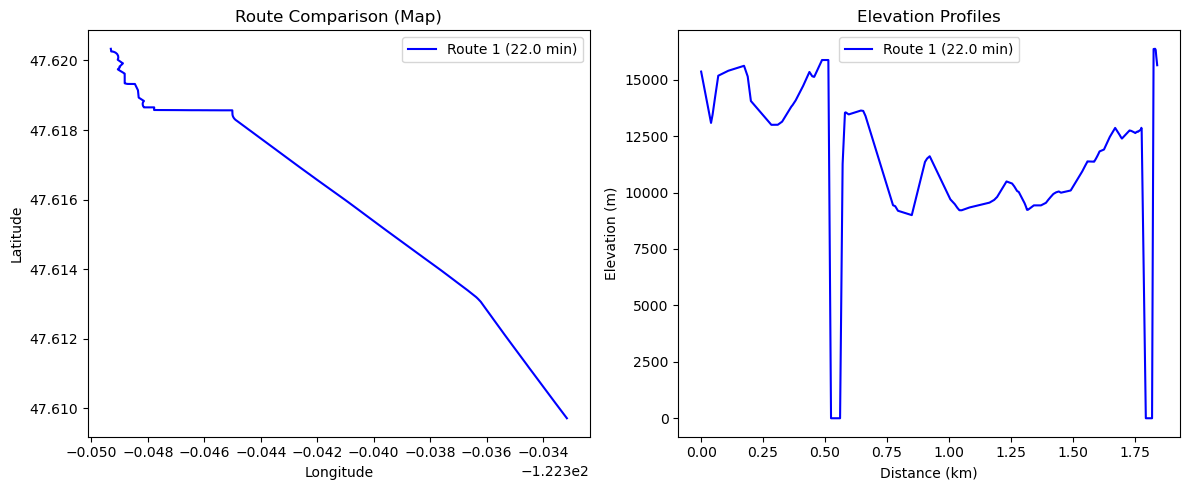

In [39]:
origin = (47.6097, -122.3331)      # Downtown Seattle
destination = (47.6205, -122.3493) # Seattle Center

routes = get_route_with_elevation(origin, destination, alternates=2)
for i, r in enumerate(routes):
    print(f"Route {i+1}: {len(r['coords'])} points, "
          f"distance {r['distances'][-1]:.2f} km, "
          f"elev range {min(r['elevations'])}-{max(r['elevations'])} m")

plot_routes(routes)


In [38]:
def total_elevation_gain(elevations):
    """Sum of all positive elevation changes (meters)."""
    gain = 0
    for i in range(1, len(elevations)):
        rise = elevations[i] - elevations[i-1]
        if rise > 0:
            gain += rise
    return gain

# Example after fetching routes
for i, r in enumerate(routes):
    gain = total_elevation_gain(r["elevations"])
    dist = r["distances"][-1]
    print(f"Route {i+1}: {dist:.2f} km, gain {gain:.1f} m")

# Pick flattest
flattest = min(routes, key=lambda r: total_elevation_gain(r["elevations"]))
print("Flattest route distance:", flattest["distances"][-1], "km")

Route 1: 1.84 km, gain 43893.0 m
Flattest route distance: 1.8406724684068012 km


In [25]:
destination = (47.6097, -122.3331)      # Downtown Seattle
origin = (47.6205, -122.3493) # Seattle Center

First 5 points with elevation + slope:
(47.620336, -122.349314) 15641 0.00% slope
(47.620303, -122.349308) 16024 10360.07% slope
(47.620282, -122.349304) 16318 12488.00% slope
(47.620261, -122.349301) 16369 2174.01% slope
(47.620252, -122.34922) 16360 -146.27% slope


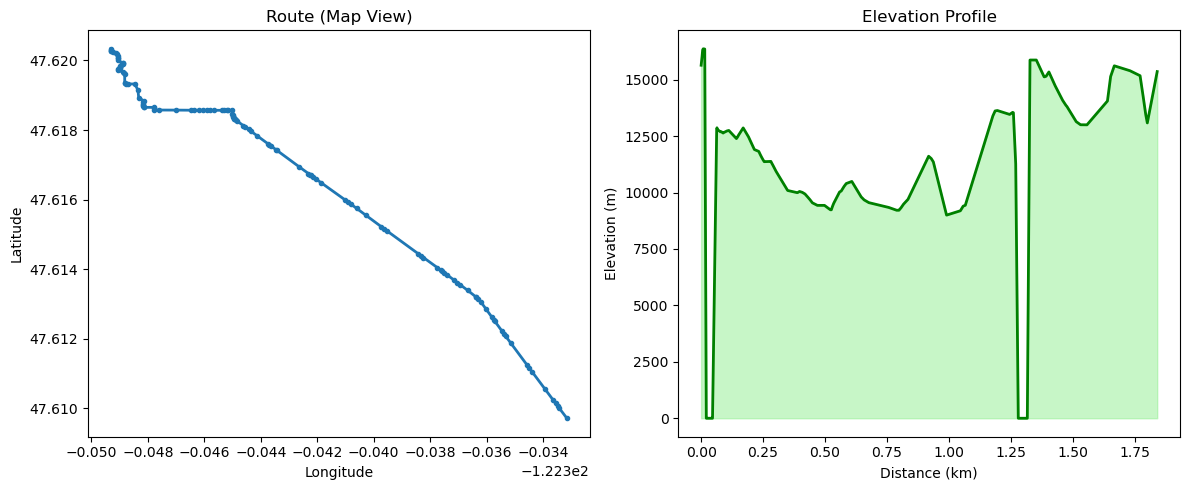

In [26]:
coords, elevations, distances, slopes = get_route_with_elevation(origin, destination)
print("First 5 points with elevation + slope:")
for i in range(5):
    print(coords[i], elevations[i], f"{slopes[i]:.2f}% slope")

plot_route(coords, elevations, distances)

In [15]:
for row in route_data[:10]:  # preview first 10 points
    print(row)

(47.609717, -122.333158, 15360, 0.0)
(47.610021, -122.333441, 13085, -5700.449735351859)
(47.610069, -122.333485, 13451, 5833.300925817601)
(47.610148, -122.333559, 14249, 7680.926963947857)
(47.610244, -122.333647, 15177, 7395.22893246636)
(47.610554, -122.333932, 15396.5, 541.2475859567551)
(47.611039, -122.334378, 15616, 345.92848293349647)
(47.611152, -122.334483, 15142, -3196.909933314232)
(47.611251, -122.334572, 14056, -8436.768406490533)
(47.611883, -122.33515, 13001, -1277.8782800547508)


In [ ]:
clean_elevations = []
for i, e in enumerate(elevations):
    

In [7]:
clean_elevations = [
    e if e is not None else (elevations[i-1] + elevations[i+1]) / 2
    for i, e in enumerate(elevations)
    if not (i == 0 or i == len(elevations)-1)  # skip first/last if None
]

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [8]:
import math

def haversine(p1, p2):
    R = 6371000  # meters
    lat1, lon1 = math.radians(p1[0]), math.radians(p1[1])
    lat2, lon2 = math.radians(p2[0]), math.radians(p2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1-a))

slopes = []
for i in range(1, len(clean_elevations)):
    rise = clean_elevations[i] - clean_elevations[i-1]
    run = haversine(coords[i-1], coords[i])  # meters
    if run > 0:
        slopes.append((rise/run)*100)

NameError: name 'clean_elevations' is not defined